<a href="https://colab.research.google.com/github/WoodComb/sleepy-parrot/blob/master/Mask_Wearers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
#install fastai
!pip install fastai

In [21]:
#    Necessary modules. I know that importing "*" is a no-no in python community, but Jeremy Howard recommends it for fastai
# library, so for now, I'll try it
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
from fastai.widgets import *

In [22]:
# We upload the csv files containing urls of the images. These haven't been cleaned, so keep that in mind. 
from google.colab import files
uploader = files.upload()

Saving masks.csv to masks.csv
Saving no_mask.csv to no_mask.csv


In [23]:
# Bash commands to make the directories and put everything in its place
!mkdir data/ data/mask data/no_mask
!mv masks.csv data/
!mv no_mask.csv data/
!cd data && ls

mkdir: cannot create directory ‘data/’: File exists
mkdir: cannot create directory ‘data/mask’: File exists
mkdir: cannot create directory ‘data/no_mask’: File exists
mask  masks.csv  models  no_mask  no_mask.csv


In [24]:
# Set the path object and check it out
path = Path('/content/data/')
path.ls()

[PosixPath('/content/data/mask'),
 PosixPath('/content/data/masks.csv'),
 PosixPath('/content/data/models'),
 PosixPath('/content/data/no_mask'),
 PosixPath('/content/data/no_mask.csv')]

In [25]:
# Download our training and validation images
download_images(path/'masks.csv', path/'mask')
download_images(path/'no_mask.csv', path/'no_mask')

In [26]:
# Check all file to see if they're images
classes = ['mask', 'no_mask']
for c in classes:
    verify_images(path/c, max_size=500)

In [27]:
# create a data loader
data = ImageDataBunch.from_folder(path, valid_pct=0.2, seed=10, ds_tfms=get_transforms() ,size=(224)).normalize(imagenet_stats)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

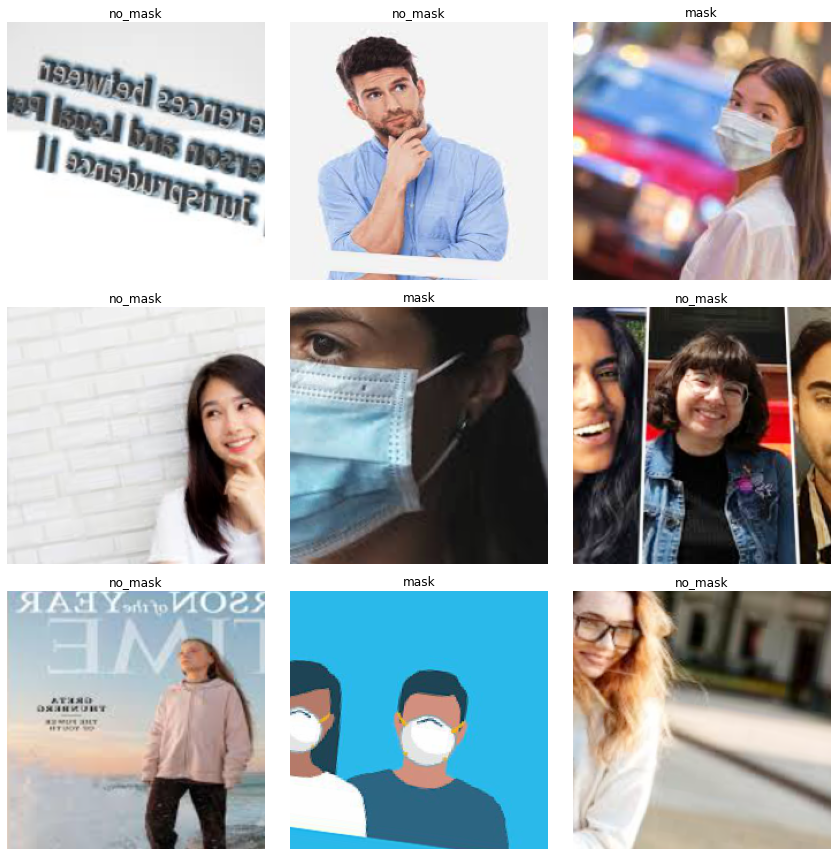

In [28]:
# lets check some of the images
data.show_batch(rows=3)

In [29]:
# Initial model. I'll use this to get the training images with top losses and remove them, because they'll most probably be mislabeled images
model_init = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate])

In [30]:
# Fitting the "head" to the pretrained model and training just that part.
model_init.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.056543,1.591878,0.812500,0.187500,00:03
1,0.885318,1.371470,0.843750,0.156250,00:03


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [31]:
# Unfreezing the rest of the model and training the entire thing for 4 epochs. We also save it, in case we need it later.
model_init.unfreeze()
model_init.fit_one_cycle(4)
model_init.save('stage-1')

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.382536,1.421298,0.812500,0.187500,00:03
1,0.463634,2.045869,0.796875,0.203125,00:03
2,0.407464,1.774952,0.875000,0.125000,00:03
3,0.361417,1.265321,0.859375,0.140625,00:03


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

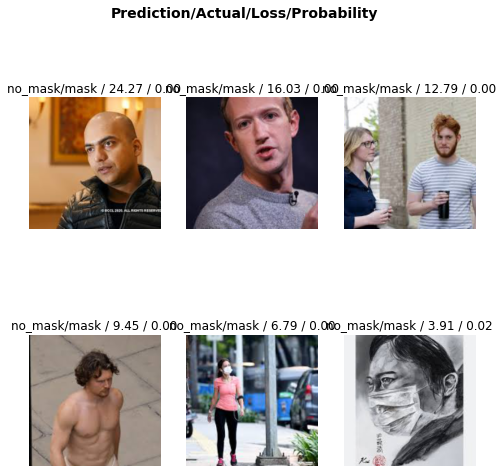

In [33]:
# Lets check out the top losses

interp = ClassificationInterpretation.from_learner(model_init)
interp.plot_top_losses(6, figsize=(8,8))

In [34]:
# We now create a new dataset, which will contain the cleaned images. This line allows the widget to consider the entire dataset
# without us having to explicitly code it in.

db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [35]:
# Lets get the images causing the top losses in our model
ds, idx = DatasetFormatter.from_toplosses(model_init)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [36]:
#   Now, we have to manually clean out this dataset. Ironically, to fully automate this, we need a model that can classify the images.

#   What if we train a model on a small dataset(~images), then have it classify images from a larger dataset(~1000), clean the classified
# images, and then train it on those immages? Would it save effort? Lets see. Another way is to create one that recognises animated images 
# and text, because a lot of these noisy images have that.

ImageCleaner(ds, idx, path)

'No images to show :)'

In [37]:
data_2 = ImageDataBunch.from_csv(path, folder='.', csv_labels='cleaned.csv', ds_tfms=get_transforms(),
                                  size=(224)).normalize(imagenet_stats)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [38]:
# Another test model

model_2 = cnn_learner(data_2, models.resnet50, metrics=[accuracy, error_rate])

#model_2.load('stage-1')

In [39]:
model_2.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.161914,4.226722,0.422222,0.577778,00:02
1,0.819095,3.515770,0.622222,0.377778,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [40]:
model_2.unfreeze()
model_2.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.406900,0.423387,0.888889,0.111111,00:02
1,0.287730,0.671053,0.844444,0.155556,00:02
2,0.297229,0.289791,0.933333,0.066667,00:02
3,0.243290,0.219312,0.955556,0.044444,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [42]:
# NICE!! We got the error down to 4%! Lets save this model, and then  try another couple of epochs
model_2.save('stage-2')
model_2.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


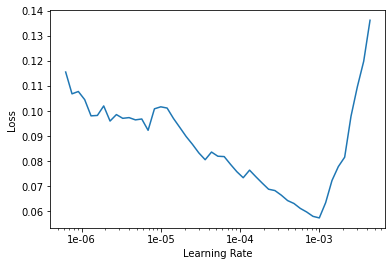

In [43]:
model_2.recorder.plot()

In [44]:
model_2.fit_one_cycle(2, max_lr=slice(1e-05, 1e-03))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.028903,0.245430,0.955556,0.044444,00:02
1,0.108517,0.263538,0.955556,0.044444,00:02


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

In [44]:
#   Okay, so this didnt change the accuracy, but the train_loss went up in the second epoch. So, lets load stage-2,
# because this is no better than that. Also, this may again be caused by noisy data, because we shouldn't get the
# exact same error in two epochs. Or it might be less data. Let's see..

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/u

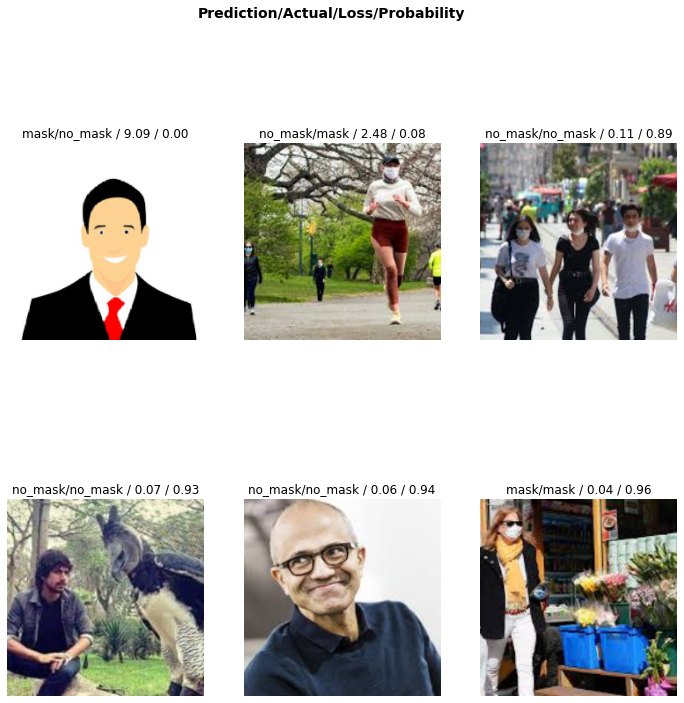

In [46]:
interp = ClassificationInterpretation.from_learner(model_2)
interp.plot_top_losses(6)